# MODELO FEDERADO

## IMPORTAR LIBRERÍAS

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random

## SEMILLA POR REPRODUCIBILIDAD

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## PREPROCESO DE LOS DATOS

In [3]:
folder_path = r"C:\Users\Ibon\PycharmProjects\Microgrid\TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess(files, all_sources):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
        df_list.append(df_sampled)
    full_df = pd.concat(df_list, ignore_index=True)
    
    full_df['source'] = pd.Categorical(full_df['source'], categories=all_sources)
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src', dtype=np.float32)
    
    return full_df

def prepare_data(df, scaler=None):
    X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
    y = df['Pmp (W)'].values.astype(np.float32)
    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    X_tensor = torch.tensor(X).to(device)
    y_tensor = torch.tensor(y).unsqueeze(1).to(device)
    return X_tensor, y_tensor, scaler

In [4]:
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

## DEFINICIÓN DE LOS HIPERPARÁMETROS
En este caso, se simulará un proceso federado de 5 rondas de 40 épocas cada una para cada uno de los clientes. El resto de hiperparámetros son los mismos que en el modelo centralizado

In [5]:
federated_rounds = 5       
local_epochs = 40          
batch_size = 512
lr = 0.0001
weight_decay = 1e-4

## SEPARACIÓN DE LOS DATOS
Se cogen los datos ya separados en el notebook TrainTestSplit

In [6]:
clients = {
    "cocoa": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "cocoa" in f.lower()],
    "eugene": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "eugene" in f.lower()],
    "golden": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "golden" in f.lower()]
}

test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]


## COGER COLUMNA SOURCE DEL ORIGEN ESPECÍFICO

In [7]:
all_sources = set()

for client_files in clients.values():
    for file in client_files:
        file_path = os.path.join(folder_path, file)
        df_temp = pd.read_csv(file_path, usecols=['source'])
        all_sources.update(df_temp['source'].unique())


all_sources = sorted(all_sources) 

In [8]:
temp_df = load_and_preprocess(clients["cocoa"], all_sources)
X_temp, y_temp, scaler = prepare_data(temp_df)  

test_df = load_and_preprocess(test_files, all_sources)

input_dim = X_temp.shape[1]

## INICIALIZACIÓN DEL MODELO Y CARGA DE PESOS DEL MODELO CENTRALIZADO

In [27]:
global_model = EnhancedDNN(input_dim).to(device)

state_dict = torch.load(r"C:\Users\Ibon\PycharmProjects\Microgrid\ModelTesting\DeepLearning\best_model_all_data.pth")

global_model.load_state_dict(state_dict)
global_model.train()

C:\Users\Ibon\AppData\Local\Temp\ipykernel_16420\2513445701.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r"C:\Users\Ibon\PycharmProjects\Micro

EnhancedDNN(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

## DEFINICIÓN DE LA FUNCIÓN DE ENTRENAMIENTO

In [28]:
def local_train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Local epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model.state_dict(), len(train_loader.dataset)

## DEFINICIÓN DE LA FUNCIÓN FEDERAGED AVERAGING PARA COMBINAR LOS PESOS DE LOS MODELOS DE CADA CLIENTE

In [29]:
def fed_avg(state_dicts, data_sizes):
    avg_state = copy.deepcopy(state_dicts[0])
    total_samples = sum(data_sizes)

    for key in avg_state.keys():
        if avg_state[key].dtype in [torch.int64, torch.long]:
            avg_state[key] = state_dicts[0][key].clone()
        else:
            avg_state[key] = torch.zeros_like(avg_state[key], dtype=torch.float32)

            for state, size in zip(state_dicts, data_sizes):
                weight = size / total_samples
                avg_state[key] += state[key].float() * weight

    return avg_state

## ENTRENAMIENTO DE CADA CLIENTE Y ACTUALIZACIÓN DEL MODELO GLOBAL

In [30]:
criterion = nn.MSELoss()
best_test_loss = np.inf
best_federated_model_path = "best_federated_model.pth"

print("=== Iniciando entrenamiento federado ===")
for round in range(1, federated_rounds+1):
    print(f"\n--- Ronda Federada {round} ---")
    local_state_dicts = []
    data_sizes = []
    for client_name, files in clients.items():
        print(f"Entrenando cliente: {client_name}")
        client_df = load_and_preprocess(files, all_sources)
        X_local, y_local, _ = prepare_data(client_df, scaler)
        local_dataset = TensorDataset(X_local, y_local)
        local_loader = DataLoader(local_dataset, batch_size=batch_size, shuffle=True)
        
        local_model = copy.deepcopy(global_model)
        optimizer_local = optim.Adam(local_model.parameters(), lr=lr, weight_decay=weight_decay)
        
        local_state, n_samples = local_train(local_model, local_loader, criterion, optimizer_local, local_epochs)
        local_state_dicts.append(local_state)
        data_sizes.append(n_samples)
    
    global_state = fed_avg(local_state_dicts, data_sizes)
    global_model.load_state_dict(global_state)
    print(f"Ronda {round} completada. Se han promediado los pesos de {len(clients)} clientes.")
    
    X_test_tensor, y_test_tensor, _ = prepare_data(test_df, scaler)
    global_model.eval()
    with torch.no_grad():
        y_pred = global_model(X_test_tensor).cpu().numpy()
        y_test_np = y_test_tensor.cpu().numpy()
        test_loss = mean_squared_error(y_test_np, y_pred)
        print(f"Test MSE después de ronda {round}: {test_loss:.4f}")
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(global_model.state_dict(), best_federated_model_path)
        print(f"Nuevo mejor modelo federado guardado: {best_federated_model_path}")



=== Iniciando entrenamiento federado ===

--- Ronda Federada 1 ---
Entrenando cliente: cocoa
Local epoch 1, Loss: 14.6027
Local epoch 2, Loss: 7.4091
Local epoch 3, Loss: 6.5190
Local epoch 4, Loss: 6.2303
Local epoch 5, Loss: 6.0878
Local epoch 6, Loss: 5.8053
Local epoch 7, Loss: 5.6516
Local epoch 8, Loss: 5.5430
Local epoch 9, Loss: 5.7208
Local epoch 10, Loss: 5.5220
Local epoch 11, Loss: 5.2682
Local epoch 12, Loss: 5.2848
Local epoch 13, Loss: 5.2792
Local epoch 14, Loss: 5.5096
Local epoch 15, Loss: 5.2136
Local epoch 16, Loss: 5.0521
Local epoch 17, Loss: 5.1567
Local epoch 18, Loss: 5.0794
Local epoch 19, Loss: 4.9246
Local epoch 20, Loss: 5.2022
Local epoch 21, Loss: 5.0923
Local epoch 22, Loss: 5.1339
Local epoch 23, Loss: 4.8902
Local epoch 24, Loss: 4.8489
Local epoch 25, Loss: 5.0503
Local epoch 26, Loss: 4.9118
Local epoch 27, Loss: 4.8893
Local epoch 28, Loss: 4.7271
Local epoch 29, Loss: 4.9979
Local epoch 30, Loss: 4.8015
Local epoch 31, Loss: 4.8456
Local epoch 32, 

## EVALUACIÓN FINAL DEL MODELO GLOBAL ACTUALIZADO FEDERADAMENTE


=== Evaluación Final del Mejor Modelo Federado ===
Test MSE: 126.0476
Test MAE: 5.0157
Test R2: 0.9129


C:\Users\Ibon\AppData\Local\Temp\ipykernel_16420\1448308357.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load(best_federated_model_

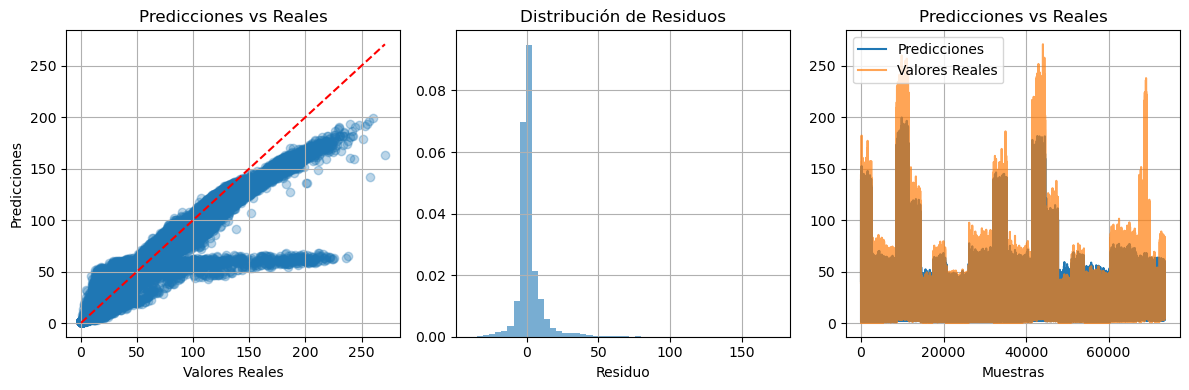

In [31]:
global_model.load_state_dict(torch.load(best_federated_model_path))
global_model.eval()
with torch.no_grad():
    y_pred = global_model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    print("\n=== Evaluación Final del Mejor Modelo Federado ===")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2: {r2:.4f}")

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Predicciones vs Reales')
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)

plt.subplot(132)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Distribución de Residuos')
plt.xlabel('Residuo')
plt.grid(True)

plt.subplot(133)
plt.plot(y_pred, label="Predicciones")
plt.plot(y_test_np, label="Valores Reales", alpha=0.7)
plt.title('Predicciones vs Reales')
plt.xlabel('Muestras')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()